# Elliptical slice sampling

This is an implementation/tutorial of the algorithm introduced by [Iain Murray et al. (2010)](https://arxiv.org/abs/1001.0175).
The goal is to sample from a posterior distribution over latent parameters that is proportional to some likelihood times a multivariate gaussian prior that ties the latents to the observed data.

Given a vector ${\bf f} \sim \mathcal{N}(0, \Sigma)$ of latent variables and a likelihood $L({\bf f}) = p(\text{data}\vert {\bf f})$, we want to sample the target distribution

$$ p^{\star}({\bf f})=\frac{1}{Z} \mathcal{N}({\bf f} ; 0, \Sigma) L({\bf f})$$ where $Z$ is a normalization constant, AKA marginal likelihood.

## Metropolis-Hastings sampling
With Metropolis-Hastings sampling, given a starting point $\mathbf{f}$, we choose our next sample, ${\bf f}^\prime = \sqrt{1-\epsilon^2}{\bf f} + \epsilon{\bf \nu}$, where $\nu \sim \mathcal{N(0,\Sigma)}$ and $\epsilon \in [-1, 1]$ is a step-size parameter.
The move from ${\bf f} \rightarrow {\bf f}^\prime$ is accepted with probability $p = \min(1,L({\bf f}^\prime)/L({\bf f}))$.


The issue with Metropolis-Hastings is that $\epsilon$ is a hyperparameter that must be determined, usually via preliminary runs of the sampler. 
We can visualize at how our choice of $\epsilon$ affects ${\bf f}^\prime$.

For a fixed $\nu$, when we vary the step size $\epsilon$ between -1 and 1, the possible ${\bf f}^\prime$s sweep out a portion of an ellipse (coloured points below).
We can instead directly parameterize these possible steps by an ellipse ${\bf f}^\prime = {\bf \nu}\sin\theta + {\bf f}\cos\theta$ (pink dashed line below); this ellipse contains ${\bf f}$ (red dot).
Note how this equation for an ellipse is no longer dependent on $\epsilon$.

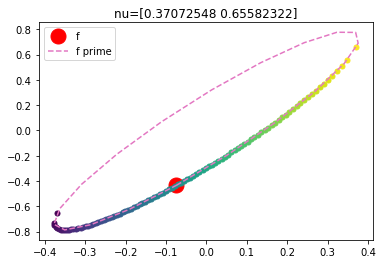

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

np.random.seed(42069)
theta = np.linspace(0, 2*np.pi, 20)

f = np.random.randn(2) # arbitrary f
nu = np.random.randn(2)  # arbitrary nu

n_pts = 100
viridis = cm.get_cmap('viridis', n_pts)

# starting point f
plt.plot(f[0], f[1], 'ro', markersize=15, label='f')

# vary epsilon from [-1, 1]
for i, e in enumerate(np.linspace(-1, 1, n_pts)):  
    f_prime = e*nu + np.sqrt(1-e**2)*f
    plt.plot(f_prime[0], f_prime[1], 'o', color=viridis(i), markersize=5, label=None)
    
# plot ellipse
f_prime = nu*np.sin(theta)[:, None] + f*np.cos(theta)[:, None]
plt.plot(f_prime[:,0], f_prime[:,1], 'C6--', label="f prime")

plt.title(f"nu={nu}")
plt.legend();

So for a given ${\bf f}$, ${\bf \nu}$ parameterizes the entire ellipse.
Choosing an $\epsilon$ (coloured dots) is equivalent to choosing an angle $\theta$ on the pink ellipse.
Vanilla slice sampling is a method by which to adaptively sample from a distribution, but naively using slice sampling rules on $\theta$ does not result in a valid Markov chain transition operator (it ends up not being reversible). Elliptical slice sampling defines a valid Markov chain transition operator with which to perform adaptive sampling using ellipse states.

## Implementing the elliptical slice sampler

The intuition here is that we can directly sample on the ellipse rather than worry about choosing a step size $\epsilon$.
We're going to write an algorithm to sample a random ${\bf \nu}$, choose a point lying on a portion (bracket) of the ellipse defined by $\nu$, then accept/reject according to a random loglikelihood threshold.
If we reject, then we adjust the size of the bracket and sample again, and repeat until we accept.
Note, now we no longer have to tune a step size parameter, and each iteration ultimately ends with an accepted sample.

The below class implements the following algorithm (from Figure 2 of the paper).

0. Define a prior covariance $\Sigma$ and mean $\mu$, 
    - sample an initial state ${\bf f} \sim \mathcal{N}({\bf 0}, \Sigma)$
1. Sample a ${\bf \nu} \sim \mathcal{N}({\bf 0}, \Sigma)$, defining an ellipse
2. Sample a log likelihood ratio:
    - $\log {\bf y} = \log L({\bf f}) + \log {\bf u}$, ${\bf u} \sim \mathrm{Uniform}[0,1]$
3. Draw an initial proposal, defining a bracket on the ellipse:
    - $\theta \sim \mathrm{Uniform}[0, 2\pi]$
    - $[\theta_{min}, \theta_{max}] = [\theta - 2\pi, \theta]$
4. ${f^\prime} = {\bf f}\cos\theta + {\bf \nu}\sin\theta$
5. if $\log L({\bf f^\prime}) > \log {\bf y}$:
    - **Accept** and return
6. else:
    - shrink the bracket and sample new point
    - if $\theta < 0$, $\theta_{min}\leftarrow \theta$,else: $\theta_{max}\leftarrow \theta$
    - $\theta \sim \mathrm{Uniform}[\theta_{min}, \theta_{max}]$
    - go back to step 4.
   
The steps above are all encapsulated in the internal method ``_indiv_sample()`` in the class.
The ``sample()`` method calls ``_indiv_sample()`` ``n_samples`` times, and throws out the first ``n_burn`` samples.

In [73]:
from typing import Callable
from scipy.stats import multivariate_normal

class EllipticalSliceSampler:
    def __init__(self, prior_mean: np.ndarray,
                 prior_cov: np.ndarray,
                 loglik: Callable):

        self.prior_mean = prior_mean
        self.prior_cov = prior_cov

        self.loglik = loglik

        self._n = len(prior_mean)  # dimensionality
        self._chol = np.linalg.cholesky(prior_cov)  # cache cholesky

        # init state; cache prev states
        self._state_f = self._chol @ np.random.randn(self._n) + prior_mean

    def _indiv_sample(self):
        """Internal method for indiv samples"""
        f = self._state_f
        nu = self._chol @ np.random.randn(self._n)  # choose ellipse
        log_y = self.loglik(f) + np.log(np.random.uniform())  # ll threshold
        
        theta = np.random.uniform(0., 2*np.pi)  # initial proposal
        theta_min, theta_max = theta-2*np.pi, theta  # define bracket
        
        while True:
            assert theta != 0
            f_prime = (f - self.prior_mean)*np.cos(theta) + nu*np.sin(theta) + self.prior_mean  
            if self.loglik(f_prime) > log_y:  # accept
                self._state_f = f_prime
                return
            
            else:  # shrink bracket and try new point
                if theta < 0:
                    theta_min = theta
                else:
                    theta_max = theta
                theta = np.random.uniform(theta_min, theta_max)

    def sample(self,
               n_samples: int,
               n_burn: int = 500) -> np.ndarray:
        """Returns n_samples samples"""
        
        samples = []
        for i in range(n_samples):
            self._indiv_sample()
            if i > n_burn:
                samples.append(self._state_f.copy())

        return np.stack(samples)

Let's define some arbitrary prior and Gaussian log likelihood from which to sample.

In [72]:
mu_prior = np.array([0., 0.])
sigma_prior = np.array([[2, -.5],
                        [-.5, 1]])

mu_lik = np.array([0, 0.])
sigma_lik = np.array([[4, 5.],
                      [5, 7]])

def loglik(f):
    """Gaussian log likelihood"""
    return np.log(multivariate_normal.pdf(f, mean=mu_lik, cov=sigma_lik))

# run our sampler!
sampler = EllipticalSliceSampler(mu_prior, sigma_prior, loglik)
samples = sampler.sample(10000, 500)

### Plot the samples
Now we can plot our samples, as well as the theoretical posterior.
Since I chose the convenient case where the liklihood and prior are both Gaussian, the posterior can be solved in closed form.
The mean is still zero since both likelihood and prior mean are zero, but the posterior covariance is
$$\Sigma_{post} = \Sigma_{prior}(\Sigma_{prior} + \Sigma_{lik})^{-1}\Sigma_{lik}.$$

With this posterior covariance, we can create a theoretical 2 stdev ellipse and see how well our samples match it.

Sample cov:
 [[0.47370139 0.2620345 ]
 [0.2620345  0.55132647]]
Theoretical cov:
 [[0.46846847 0.26126126]
 [0.26126126 0.54954955]]


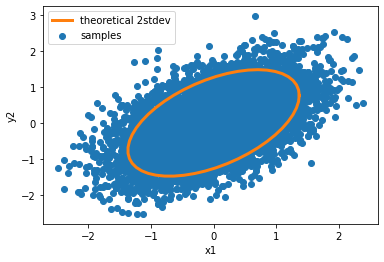

In [70]:
# compute posterior covariance and correlate a circle of points to match the distribution
sigma_post = sigma_prior@np.linalg.inv(sigma_prior + sigma_lik)@sigma_lik
chol_post = np.linalg.cholesky(sigma_post)
th = np.linspace(0, 2*np.pi, 50)
pts = np.array([np.cos(th),
                np.sin(th)])
rot = 2 * chol_post @ pts  # 2 stdev ellipse

# plot it
plt.scatter(samples[:,0], samples[:,1], label='samples')
plt.plot(rot[0,:], rot[1,:], 'C1', linewidth=3, label='theoretical 2stdev')
plt.gca().set(xlabel='x1', ylabel='y2')
plt.legend();

print("Sample cov:\n", np.cov(samples.T))
print("Theoretical cov:\n", sigma_post)

Not bad! 
This was pretty straightforward to implement.
The upside is that regardless of dimensionality of the posterior, the parameter space will always lie on a 2D plane.
The downside is that this sampler is only valid when the prior is Gaussian.